# Semantic Segmentation with PyTorch

In this exercise, you'll use the U-Net network to perform binary classification and segmentation for images of planes.

## Install PyTorch

To begin with, we'll install the latest version of PyTorch, and import the libraries we need.

In [1]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as td

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.0.1.post2


## Import the U-Net Code

The code to implement U-Net is provided in the **model.py** python file.

> **Tip**: You should explore the code in this file to get a better understanding of the way the model works.


In [2]:
from unet_pytorch.model import *

## Explore the Training Data

The training data for a U-Net model consists of two kinds of input:

- **Image files**: The images that represent the *features* on which we want to train the model.
- **Mask files**: Images of the object masks that the network will be trained to predict - these are the *labels*.

In this example, we're going to use U-Net for binary classification of airplanes images, so there's only one class of object - and therefore one class of mask. We've deliberately made this example as simple as possible, partly to make it easier to understand what's going on, and partly to ensure it can be run in a resource-constrained environment. 

Let's take a look at the training images and masks:

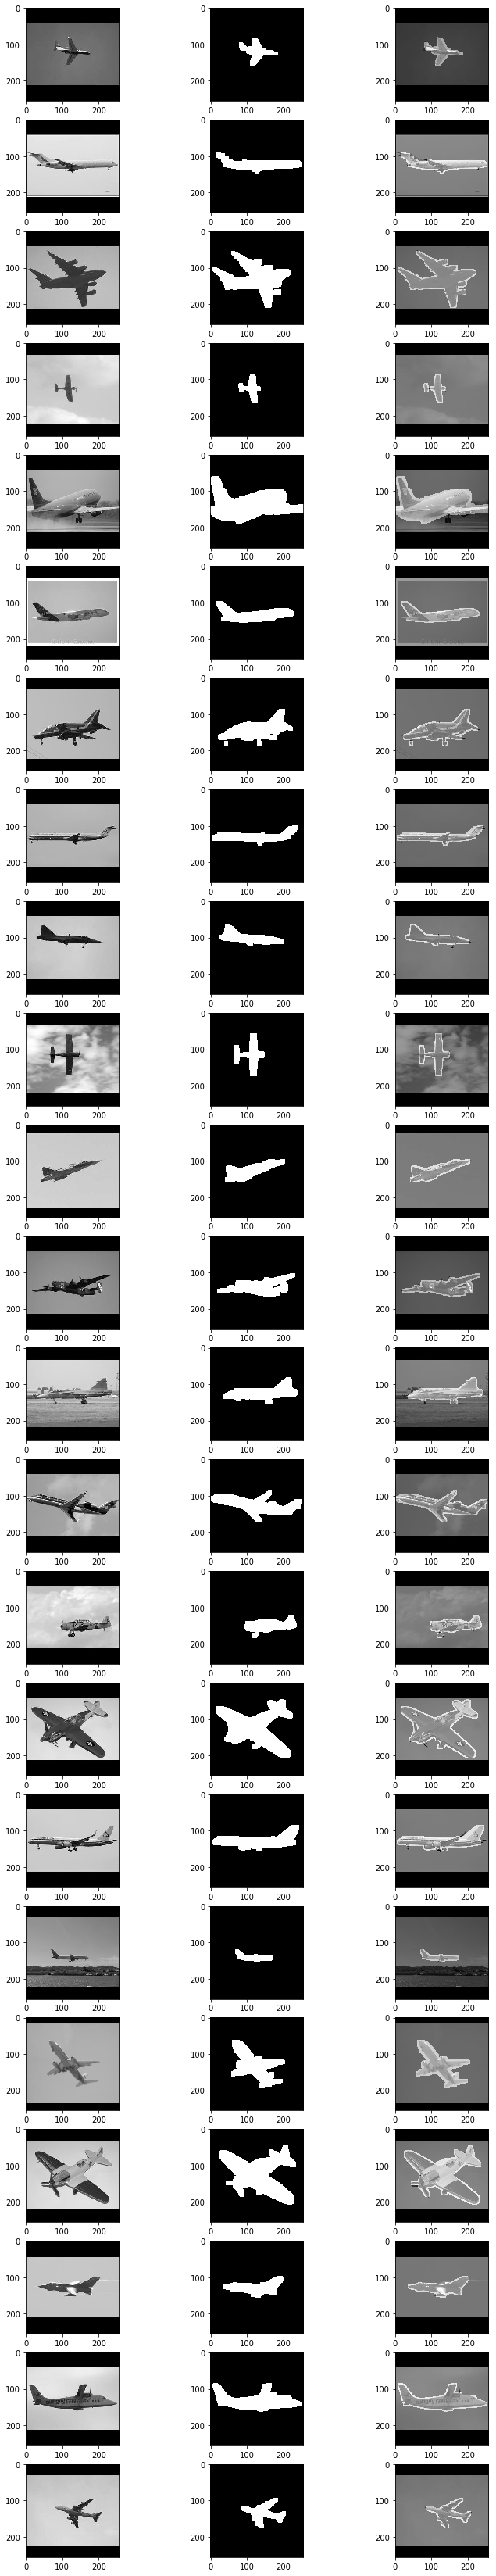

In [3]:
import os
from matplotlib import pyplot as plt
import skimage.io as io
import numpy as np
%matplotlib inline


fig = plt.figure(figsize=(12, 60))

train_dir = 'data/train'
image_dir = os.path.join(train_dir,"image/plane")
mask_dir = os.path.join(train_dir,"mask/plane")

files = os.listdir(image_dir)
rows = len(files)
cell = 0
for file in files:
    cell += 1
    
    # Open the image and mask files
    img_path = os.path.join(image_dir, file)
    img = io.imread(img_path, as_gray = True)
    
    mask_path = os.path.join(mask_dir, file)
    mask = io.imread(mask_path, as_gray = True)
    
    # plot the image
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    cell += 1

    # plot the mask
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(mask, "gray")
    cell += 1
    
    # Plot them overlaid
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    imgplot=plt.imshow(mask, "gray", alpha=0.4)

plt.show()



## Load the Training Data

To load the images, we'll define a custom PyTorch dataset that gets each image and its corresponding mask.

We have a very small number of training images, so we'll apply some data augmentation to randomly flip the images.

In [4]:
class PlaneDataSet(td.Dataset):
    
    def __init__(self, image_path, mask_path, transform):
        import os
        
        self.image_path = image_path
        self.mask_path = mask_path
        self.filenames = os.listdir(mask_path)
        self.transform = transform
        
    def __getitem__(self, index):
        import os
        import random
        import numpy as np
        rand = random.randint(0, 2)        

        from PIL import Image
        import skimage.io as io
        
        img_path = os.path.join(self.image_path, self.filenames[index])
        image =  io.imread(img_path, as_gray = True)
        image_np = image/255
        if rand > 1:
            image_pil = Image.fromarray(image_np).transpose(Image.FLIP_LEFT_RIGHT)            
            image_np = np.array(image_pil)
            
        image_np = np.expand_dims(image_np, axis=0)
        image_tensor = torch.from_numpy(image_np).float()
        
        mask_path = os.path.join(self.mask_path, self.filenames[index])
        mask =  io.imread(mask_path, as_gray = True)
        mask_np = mask/255
        if rand > 1:
            mask_pil = Image.fromarray(mask_np).transpose(Image.FLIP_LEFT_RIGHT).convert("L")            
            mask_np = np.array(mask_pil)
        mask_np = np.expand_dims(mask_np, axis=0)
        mask_tensor = torch.from_numpy(mask_np).float()
        
        return(image_tensor, mask_tensor)
    
    def __len__(self):
        return len(self.filenames)
                           
     

Now we can use our dataset to create a data loader that gets batches of training data.

In [5]:
# Function to ingest data
def load_data(image_path, mask_path):
    # Load all of the images
    transformation = transforms.Compose([  
        # transform to tensors
        transforms.ToTensor()
    ])

    # Load all of the images, transforming them
    dataset = PlaneDataSet(image_path , mask_path, transform=transformation)
    
    # define a loader for the image data
    image_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=2,
        num_workers=0,
        shuffle=True
    )
    
        
    return image_loader

image_path = "data/train/image/plane"
label_path = "data/train/mask/plane"

image_loader = load_data(image_path, label_path)


## Train the Model

Now we're ready to train the U-Net model. We'll train it from the data loader we created.

After training is complete, we'll save the model weights.

In [6]:
def train(model, device, data_loader, optimizer, epoch):
    
    model.to(device)
    model.train()
    
    train_loss = 0
    print("Epoch:", epoch, "...")
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(data_loader):
        
        
        data, target = Variable(data.to(device)), Variable(target.to(device))
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_training_loss = train_loss / len(data_loader.dataset)
    print("\tTraining set: Average loss: {:.6f}".format(avg_training_loss))
    return avg_training_loss

# Create a UNet model
model = UNet(n_channels=1, n_classes = 1)

# Specify the optimizer and  loss criteria
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_criteria = nn.BCELoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []

# Use the best available device (GPU/CPU) for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 200
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, image_loader, optimizer, epoch)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)

# Save the model weights
torch.save(model.state_dict(), 'unet_pytorch/unet.pt')
print("Model saved.")

Training on cuda
Epoch: 1 ...
	Training set: Average loss: 0.233300
Epoch: 2 ...
	Training set: Average loss: 0.124197
Epoch: 3 ...
	Training set: Average loss: 0.106980
Epoch: 4 ...
	Training set: Average loss: 0.083924
Epoch: 5 ...
	Training set: Average loss: 0.074615
Epoch: 6 ...
	Training set: Average loss: 0.075954
Epoch: 7 ...
	Training set: Average loss: 0.067573
Epoch: 8 ...
	Training set: Average loss: 0.063828
Epoch: 9 ...
	Training set: Average loss: 0.063700
Epoch: 10 ...
	Training set: Average loss: 0.058059
Epoch: 11 ...
	Training set: Average loss: 0.055369
Epoch: 12 ...
	Training set: Average loss: 0.062841
Epoch: 13 ...
	Training set: Average loss: 0.058525
Epoch: 14 ...
	Training set: Average loss: 0.068754
Epoch: 15 ...
	Training set: Average loss: 0.054347
Epoch: 16 ...
	Training set: Average loss: 0.051003
Epoch: 17 ...
	Training set: Average loss: 0.053849
Epoch: 18 ...
	Training set: Average loss: 0.044877
Epoch: 19 ...
	Training set: Average loss: 0.044890
Epoc

	Training set: Average loss: 0.012638
Epoch: 159 ...
	Training set: Average loss: 0.016926
Epoch: 160 ...
	Training set: Average loss: 0.015111
Epoch: 161 ...
	Training set: Average loss: 0.016627
Epoch: 162 ...
	Training set: Average loss: 0.018490
Epoch: 163 ...
	Training set: Average loss: 0.015839
Epoch: 164 ...
	Training set: Average loss: 0.014944
Epoch: 165 ...
	Training set: Average loss: 0.021230
Epoch: 166 ...
	Training set: Average loss: 0.019135
Epoch: 167 ...
	Training set: Average loss: 0.015620
Epoch: 168 ...
	Training set: Average loss: 0.015985
Epoch: 169 ...
	Training set: Average loss: 0.027563
Epoch: 170 ...
	Training set: Average loss: 0.018254
Epoch: 171 ...
	Training set: Average loss: 0.014949
Epoch: 172 ...
	Training set: Average loss: 0.015149
Epoch: 173 ...
	Training set: Average loss: 0.013048
Epoch: 174 ...
	Training set: Average loss: 0.012571
Epoch: 175 ...
	Training set: Average loss: 0.011406
Epoch: 176 ...
	Training set: Average loss: 0.012605
Epoch: 1

## Test the Trained Model

OK, let's see how well our trained model does with some images of airplanes it hasn't seen.

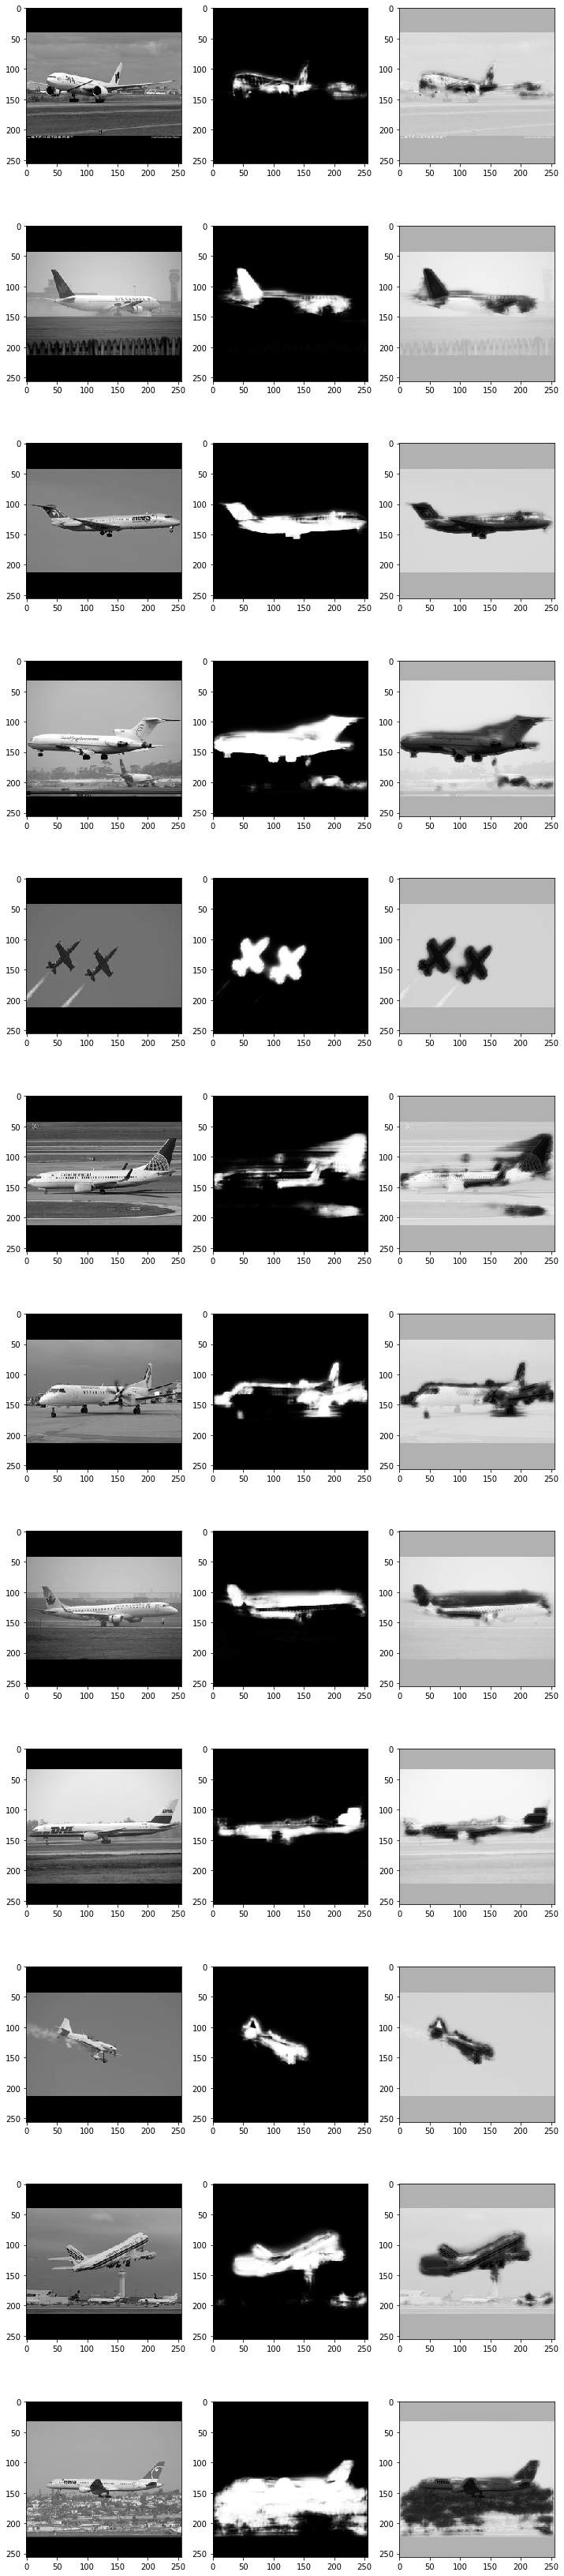

In [9]:
import os
from matplotlib import pyplot as plt
import skimage.io as io
from unet_pytorch.model import *
import numpy as np
%matplotlib inline

#Create a new instance of the model and load the save weights
model = UNet(n_channels=1, n_classes = 1)
model.load_state_dict(torch.load('unet_pytorch/unet.pt'))
model.eval()

transformation = transforms.Compose([  
        # transform to tensors
        transforms.ToTensor()
    ])



fig = plt.figure(figsize=(12, 60))


imgdir = 'data/test'
#imgdir = "data/train/image/plane"

files = os.listdir(imgdir)
rows = len(files)
cell = 0
for file in files:
    cell += 1
    # Open the file
    img_path = os.path.join(imgdir, file)
    img =  io.imread(img_path, as_gray = True)
    image_tensor = Variable(torch.stack([transformation(img)]))
    
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    cell += 1
    
    with torch.no_grad():
        mask_predictions = model(image_tensor)
    mask = mask_predictions.data.numpy()[0]
    img_mask = mask[0]
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img_mask, "gray")
    cell += 1

    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    imgplot=plt.imshow(img_mask, "binary", alpha=0.7)

plt.show()



It's not fantastic, largely because we used such a small amount of data; but hopefully it serves to demonstrate the principles of semantic segmentaion with U-Net.

## Acknowledgements and Citations

The U-Net architecture is documented by its inventors (Olaf Ronneberger, Philipp Fischer, and Thomas Brox), at https://arxiv.org/abs/1505.04597.

The PyTorch implementation of U-Net used in this exercise is based on milesial's work at https://github.com/milesial/Pytorch-UNet, with some simplifications. 

The data used in this exercise includes images adapted from the PASCAL Visual Object Classes Challenge (VOC2007) dataset at http://host.robots.ox.ac.uk/pascal/VOC/voc2007/.


    @misc{pascal-voc-2007,
        author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
        title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2007 {(VOC2007)} {R}esults",
        howpublished = "http://www.pascal-network.org/challenges/VOC/voc2007/workshop/index.html"}

